<a href="https://colab.research.google.com/github/AbdelRayan/ThetaGammaAnalysis/blob/main/notebooks/Tutorial_3_Frequency_Phase_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
pip install emd

In [86]:
pip install sails

In [87]:
import numpy as np
import scipy.io as sio
import scipy
from scipy.stats import binned_statistic
import emd.sift as sift
import emd.spectra as spectra
import matplotlib.pyplot as plt

In [88]:
# Scientific to Float Print Format
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.7f}'.format})

In [89]:
# Tutorial 1 Summary and pre-loading variables

## Loading data
lfp=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/HPC_100_CH42_0.continuous.mat')['HPC'])
states=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/2022-02-08_14-47-29_posttrial5-states_TS.mat')['states'])

In [90]:
 #Tutorial 1 Summary

def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

    # Defining the theta gamma split function

def tg_split(mask_freq, theta_range=(5, 12)):
    """
        Split a frequency vector into sub-theta, theta, and supra-theta components.

        Parameters:
        mask_freq (numpy.ndarray): A frequency vector or array of frequency values.
        theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

        Returns:
        tuple: A tuple containing boolean masks for sub-theta, theta, and supra-theta frequency components.

        Notes: - This function splits a frequency mask into three components based on a specified theta frequency
        range. - The theta frequency range is defined by the 'theta_range' parameter. - The resulting masks 'sub',
        'theta', and 'supra' represent sub-theta, theta, and supra-theta frequency components.
    """
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index

    return sub, theta, supra

In [91]:
# Tutorial 2 Summary

def zero_cross(x):
    """
    Find the indices of zero-crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    numpy.ndarray: An array of indices where zero-crossings occur in the input signal.

    Notes:
    - This function identifies the indices where zero-crossings occur in a given 1D signal.
    - It detects both rising and falling zero-crossings.
    """
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    zero_xs = np.sort(np.append(rise, decay))
    return zero_xs

def extrema(x):
    """
    Find extrema (peaks, troughs) and zero crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    tuple: A tuple containing:
        - numpy.ndarray: Indices of zero-crossings in the input signal.
        - numpy.ndarray: Indices of troughs in the input signal.
        - numpy.ndarray: Indices of peaks in the input signal.

    Notes:
    - This function identifies and returns the indices of zero-crossings, troughs, and peaks in a given 1D signal.
    - Zero-crossings are points where the signal crosses the zero axis.
    - Troughs are local minima, and peaks are local maxima in the signal.
    """
    zero_xs = zero_cross(x)
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    return zero_xs, troughs, peaks


# The wavelet transform

In our previous tutorial we extracted the theta cycles, that provided us the exact locations durations and magnitudes of theta oscillations. Given that gamma oscillations are nested under theta, our extracted cycles only provides information regarding in theta frequency band and we would like to extract information in the gamma band and develop some form of meaningful relationship to theta.

We utilize the Morlet Wavelet Transform form the `sails` library to decompose the theta signal within a given frequency range (15 to 140 Hz). This generates a frequency by time matrix that can be plotted to show the variation of amplitude or power across the selected period of REM sleep.


In [92]:
# Importing the morlet function from the sails library
import sails

In [93]:
# Load the REM states and pick the first REM period
s_rate= 2500
rem_states=get_rem_states(states, s_rate).astype(int)
first_rem=lfp[rem_states[0,0]:rem_states[0,1]] # Load the first REM epoch for our example

# Generate the IMFs
imask=sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')

# Extract the theta signal
sub_theta, theta, supra_theta = tg_split(imask[1])
theta_sig=np.sum(imask[0].T[theta],axis=0)
supra_theta_sig=np.sum(imask[0].T[supra_theta],axis=0)
sub_theta_sig= np.sum(imask[0].T[sub_theta],axis=0)

In [94]:
# Call the morlet wavelet transform function and generate Morlet wavelet spectograms

sample_rate = 2500
frequencies= np.arange(15,141,1)
theta_range=(5,12)
time=len(first_rem)/s_rate
seconds=np.linspace(0,time,len(first_rem))

first_rem_wt= sails.wavelet.morlet(first_rem, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)
theta_wt= sails.wavelet.morlet(theta_sig, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)
supra_theta_wt= sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)

Text(0, 0.5, 'Frequency (Hz)')

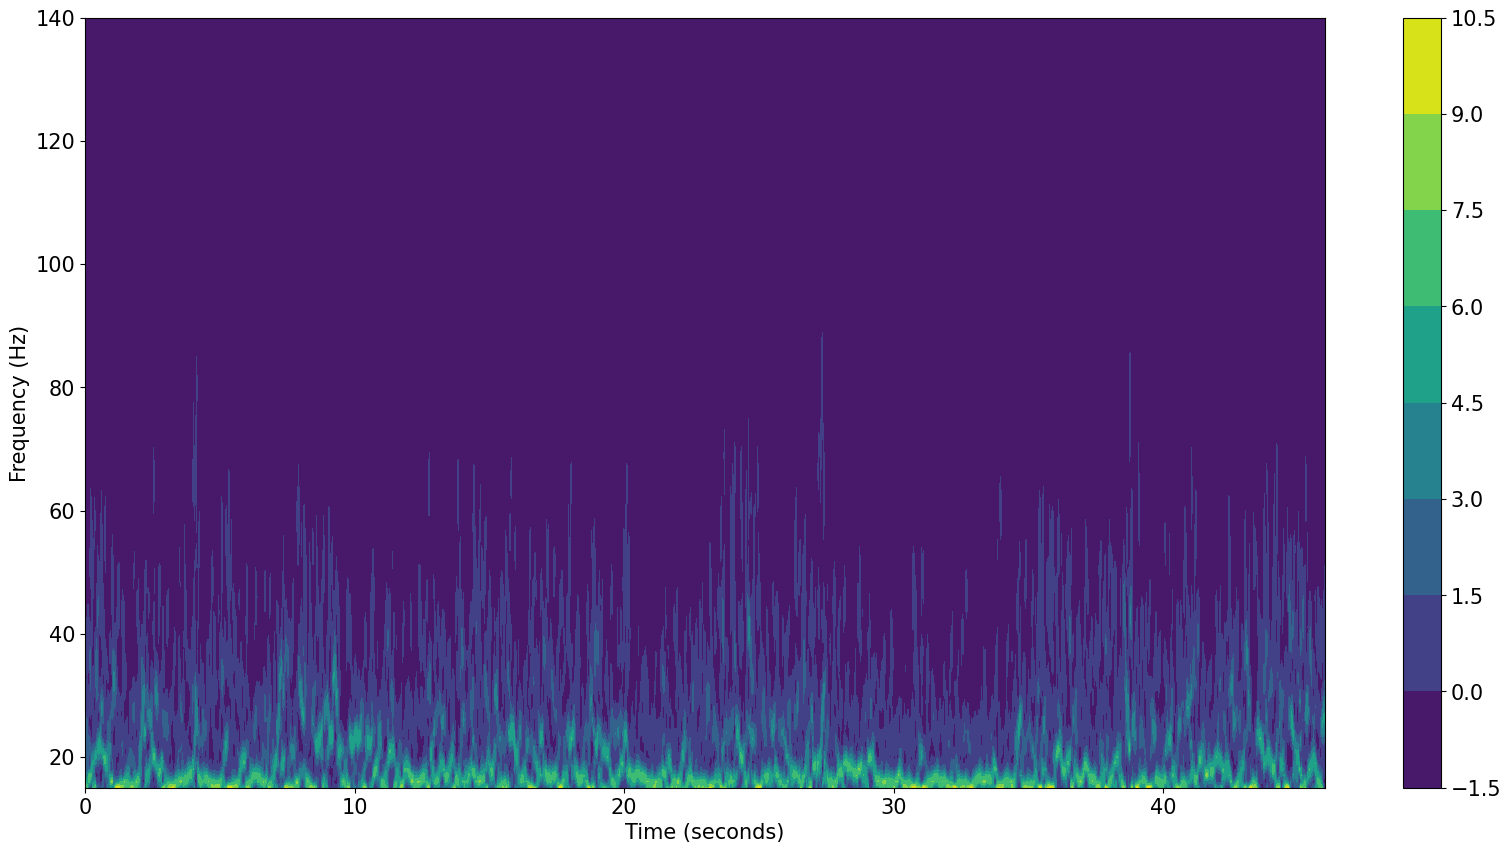

In [95]:
#@title Normalized Raw Signal Wavelet Transform

plt.gcf().set_size_inches(20, 10)
first_rem_wt=scipy.stats.zscore(first_rem_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,first_rem_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

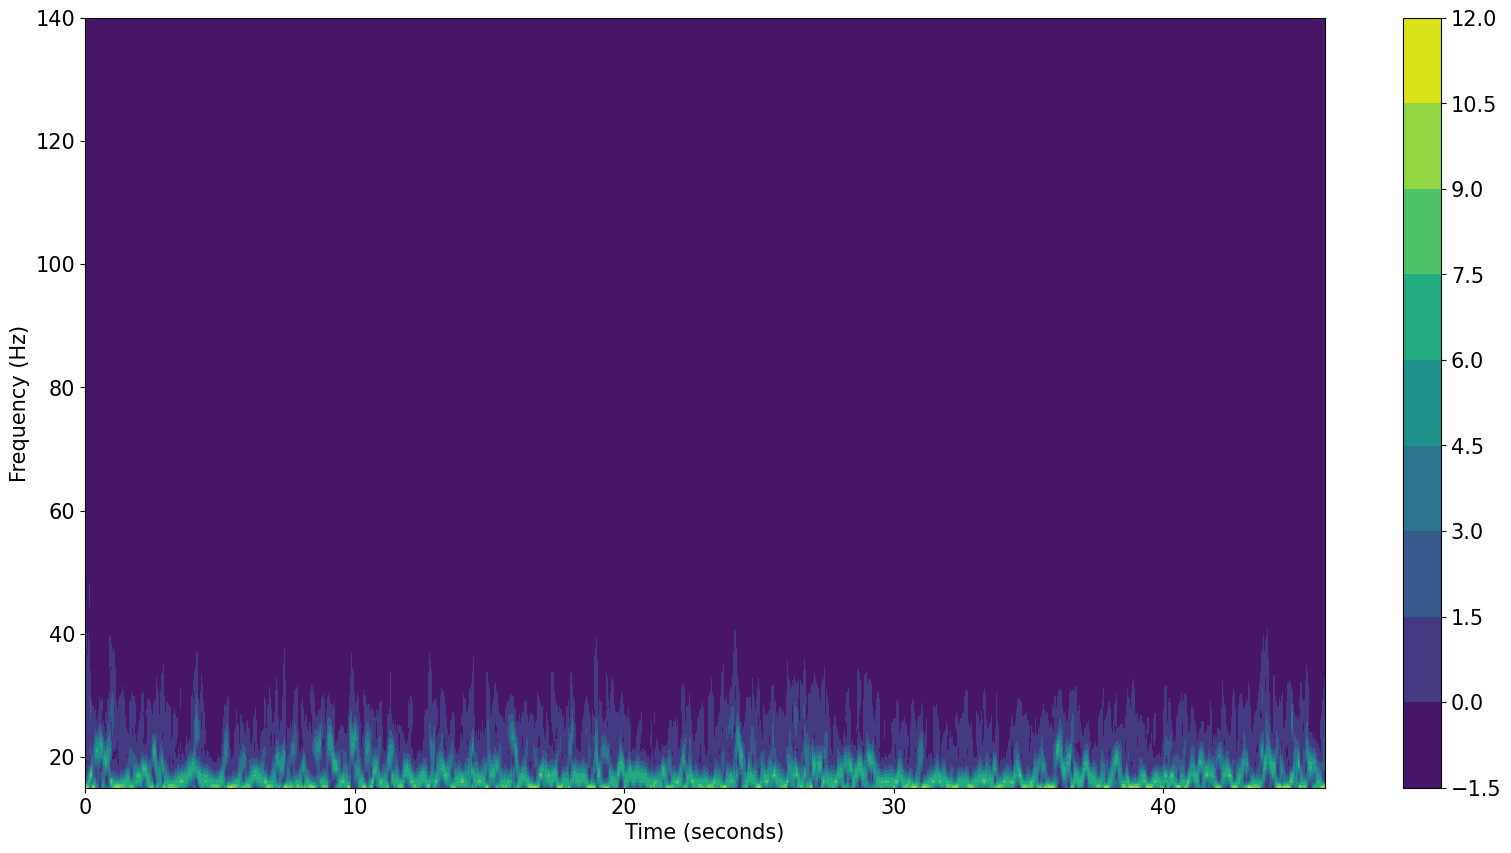

In [96]:
#@title Normalized Theta Signal Wavelet Transform

plt.gcf().set_size_inches(20, 10)
theta_wt=scipy.stats.zscore(theta_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,theta_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

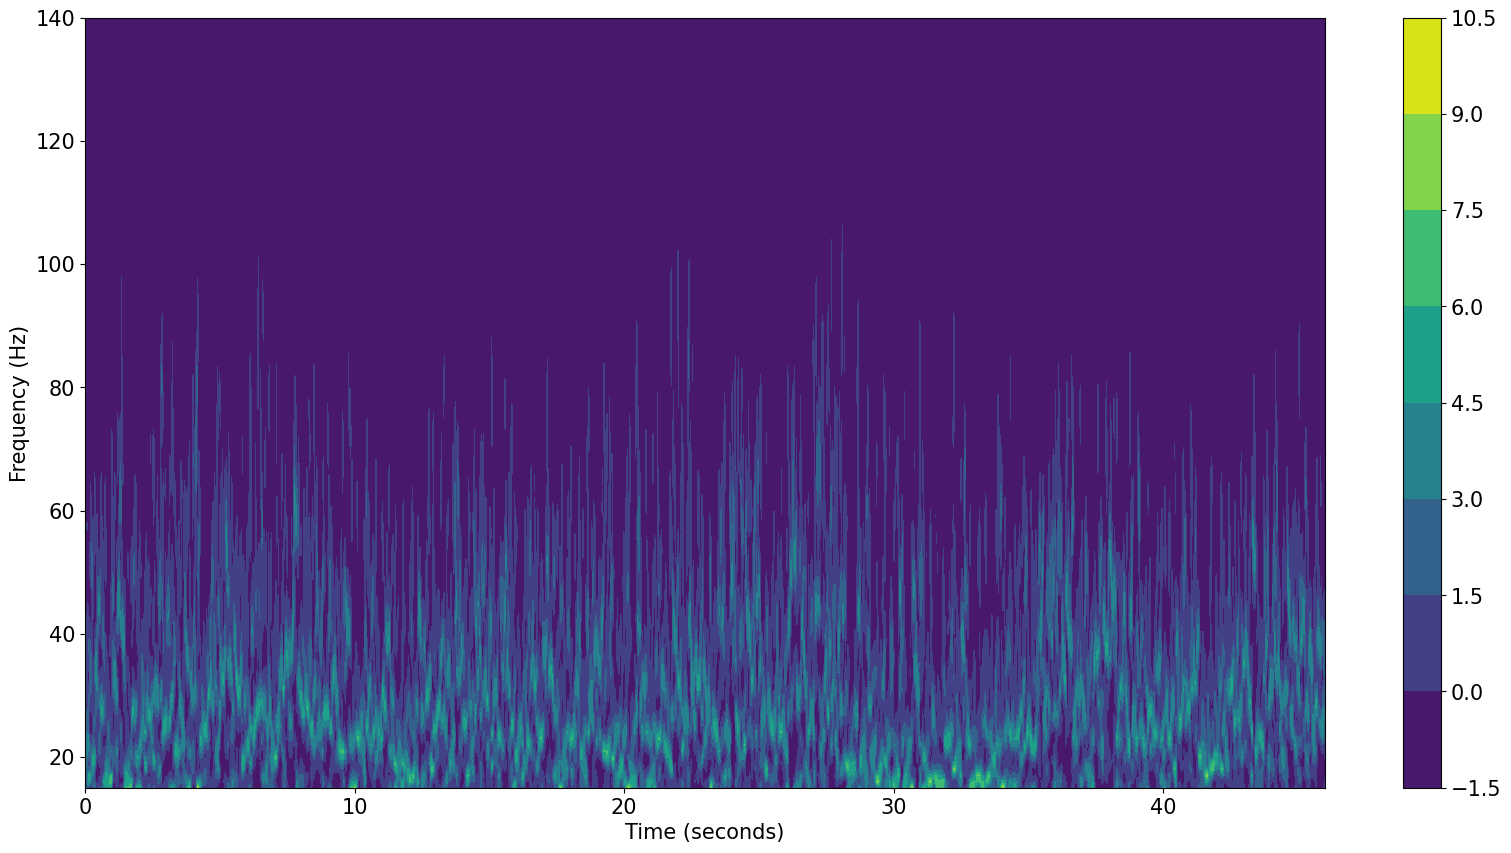

In [97]:
#@title Normalized Supra-Theta Signal Wavelet Transform

plt.gcf().set_size_inches(20, 10)
supra_theta_wt=scipy.stats.zscore(supra_theta_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,supra_theta_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

# Building an indexed dataset from a time-frequency matrix

Given that we can extract cycles from our cycles with respect to their appropriate indices on the signal data length, we can use those indices to parse the wavelet transform regions such that we can build a dataset of $n$ cycles and homogenize the time dimension to phase generating a Frequency Phase-Power Matrix (FPP)



In [98]:
# Define a morlet wavelet transform function
def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    """
        Compute the Morlet Wavelet Transform of a signal.

        Parameters: x (numpy.ndarray): The input signal for which the Morlet Wavelet Transform is computed.
        sample_rate (int or float): The sampling rate of the input signal. frequencies (numpy.ndarray, optional): An
        array of frequencies at which to compute the wavelet transform. Default is a range from 1 to 200 Hz with a
        step of 1 Hz. n (int, optional): The number of cycles of the Morlet wavelet. Default is 5. mode (str,
        optional): The return mode for the wavelet transform. Options are 'complex' (default),'amplitude', and 'power'.

        Returns:
        numpy.ndarray: The Morlet Wavelet Transform of the input signal.

        Notes: - This function computes the Morlet Wavelet Transform of a given signal. - The wavelet transform is
        computed at specified frequencies. - The number of cycles for the Morlet wavelet can be adjusted using the
        'n' parameter. - The result can be returned in either complex or magnitude form either as amplitude or power,
        as specified by the 'mode' parameter.
    """
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    return wavelet_transform


In [99]:
# Tutorial 2 Summary
def get_cycles_data(x, rem_states, sample_rate, frequencies, theta_range=(5, 12)):
    """
    Generate a nested dictionary containing extracted data and desired metadata of each REM epochs in the input sleep
    signal

    Parameters:
    x (numpy.ndarray): The input 1D sleep signal.
    rem_states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.
    theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

    Returns:
    rem_dict: A nested dictionary of extracted signal data and signal source metadata

    Notes:
    - The dictionary output structure comes out as below:
        |----REM 1
        |    |----start_end:
        |    |----IMFs:
        |    |----IMF Frequencies:
        |    |----Instantaneous Phases:
        |    |----Instantaneous Frequencies:
        |    |----Instantaneous Amplitudes:
        |    |----Cycles:
        |----REM (...)
        |    |--------(...)
    """

    # Squeezing dimensions
    x = np.squeeze(x)
    rem_states = np.squeeze(rem_states)

    print(x.shape)
    print(rem_states.shape)

    # Detect REM periods
    consecutive_rem_states = get_rem_states(rem_states, sample_rate).astype(int)

    if consecutive_rem_states.ndim == 3:
        consecutive_rem_states=np.squeeze(consecutive_rem_states,0)

    print(consecutive_rem_states.shape)

    # Intiializing variables
    wt_spectrum = []
    rem_imf = []
    rem_mask_freq = []
    instantaneous_phase = []
    instantaneous_freq = []
    instantaneous_amp = []
    sub_theta_sig = np.empty((0,))
    theta_peak_sig = np.empty((0,))
    cycles = np.empty((0, 5))
    rem_dict = {}
    sub_dict = rem_dict
    good_rem = []
    count = 0
    # Loop through each REM epoch
    for i, rem in enumerate(consecutive_rem_states):
        start = rem[0]
        end = rem[1]+1
        signal = x[start:end]

        # Extraction of IMFs and IMF Frequencies for current REM epoch
        print('Finding Intrinsic Mode Functions')
        imf, mask_freq = sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)

        # Extract Instantaneous Phase, Frequencies and Amplitudes of each IMF for current REM epoch
        print('Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF')
        IP, IF, IA = spectra.frequency_transform(imf, sample_rate, 'nht')

        # Identify sub-theta, theta, and supra-theta frequencies
        sub_theta, theta, supra_theta = tg_split(mask_freq, theta_range)

        if np.any(theta):
            print('Theta frequencies are valid')
            count += 1
            good_rem.append(i)
            sub_dict.setdefault(f'REM {count}', {})
        elif not np.any(theta):
            print(f'No valid theta frequencies for REM {i}')
            continue

        print(f'Processing REM {count} ')

        # Generate the time-frequency power spectrum
        print('Generating time-frequency matrix')
        wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        # print('Generating time-frequency matrix')
        # if wavelet =='theta':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[theta], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # elif wavelet == 'gamma':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[supra_theta], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # else:
        #     wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        wt_spectrum.append(wavelet_transform)
        rem_imf.append(imf)
        rem_mask_freq.append(mask_freq)
        instantaneous_phase.append(IP)
        instantaneous_freq.append(IF)
        instantaneous_amp.append(IA)

        # Generate the theta signal to detect cycles
        theta_sig = np.sum(imf.T[theta], axis=0)

        # Parse the sub-theta signal of all REM periods into one variable to set amplitude threshold
        sub_theta_sig = np.append(sub_theta_sig, np.sum(imf.T[sub_theta], axis=0))

        # Generate extrema locations and zero crossing on the generated theta signal
        zero_x, trough, peak = extrema(np.sum(imf.T[theta], axis=0))
        print(f'Number of zero crossings, {zero_x.shape}')

        # Create the cycles array for the current REM epoch
        zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

        size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
        zero_x = zero_x[:size_adjust]
        cycle = np.empty((size_adjust, 5))
        cycle[:, [0, 2, 4]] = zero_x
        if trough[0] < peak[0]:
            cycle[:, 1] = trough[:zero_x.shape[0]]
            cycle[:, 3] = peak[:zero_x.shape[0]]
        else:
            cycle[:, 3] = trough[:zero_x.shape[0]]
            cycle[:, 1] = peak[:zero_x.shape[0]]

        broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

        adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                         axis=0) == True)
        adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

        fixed_cycle = broken_cycle[1:-1]
        if adjust_condition:
            fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
            fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
        else:
            fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
            fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

        cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        cycle = np.vstack((cycle, fixed_cycle))
        if trough[0] < peak[0]:
            cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
        else:
            cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))
        print(f'Number of cycles, {cycle.shape}')
        # Create an array of amplitudes at the peaks
        theta_peak_sig = np.append(theta_peak_sig, theta_sig[cycle[:, 2].astype(int)])
        cycles = np.vstack((cycles, cycle + start))

    # Set the minimum amplitude threshold and discard unsatisfactory theta peaks
    min_peak_amp = 2 * sub_theta_sig.std()
    peak_mask = theta_peak_sig > min_peak_amp

    # Set the frequency threshold and discard and unsatisfactory difference between trough pairs
    upper_diff = np.floor(1000 / np.min(theta_range))
    lower_diff = np.floor(1000 / np.max(theta_range))
    diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                               np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)

    # Create a boolean mask that satisfy both the frequency and amplitude threshold criteria
    extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)

    # Pass the boolean mask on the cycles array to discard any unsatisfactory cycles
    cycles = cycles[extrema_mask]

    # Place outputs in a nested dictionary
    for j, rem in enumerate(rem_dict.values()):
        good_rem_states = consecutive_rem_states[good_rem]
        rem['start-end'] = good_rem_states[j]
        rem['wavelet_transform'] = wt_spectrum[j]
        rem['IMFs'] = rem_imf[j]
        rem['IMF_Frequencies'] = rem_mask_freq[j]
        rem['Instantaneous Phases'] = instantaneous_phase[j]
        rem['Instantaneous Frequencies'] = instantaneous_freq[j]
        rem['Instantaneous Amplitudes'] = instantaneous_amp[j]
        cycles_mask = (cycles > good_rem_states[j, 0]) & (cycles < good_rem_states[j, 1])
        cycles_mask = np.all(cycles_mask == True, axis=1)
        if cycles[cycles_mask].size == 0:
            rem_cycles = np.zeros((1, 5)).astype(int) # Empty Cycles Array (none of the cycles passed our thresholds)
        else:
            rem_cycles = cycles[cycles_mask].astype(int)
        rem['Cycles'] = rem_cycles

    return rem_dict

In [100]:
# To demonstrate one example let's extract the cycles of the first REM period
rem_dict=get_cycles_data(lfp,states,sample_rate,frequencies)

(27009280,)
(10803,)
(8, 2)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 1 
Generating time-frequency matrix
Number of zero crossings, (751,)
Number of cycles, (374, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 2 
Generating time-frequency matrix
Number of zero crossings, (240,)
Number of cycles, (118, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 3 
Generating time-frequency matrix
Number of zero crossings, (273,)
Number of cycles, (135, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 4 
Generating time-frequency matrix
Number of zero crossings, (1434,)
Number of cycles, (715, 5)

In [101]:
first_rem_cycles=rem_dict['REM 1']['Cycles']
print(first_rem_cycles.shape)
first_rem_wt=rem_dict['REM 1']['wavelet_transform']
print(first_rem_wt.shape)

(331, 5)
(126, 115001)


Text(0.5, 1.0, 'Single cycle Supra-theta Signal TF Matrix')

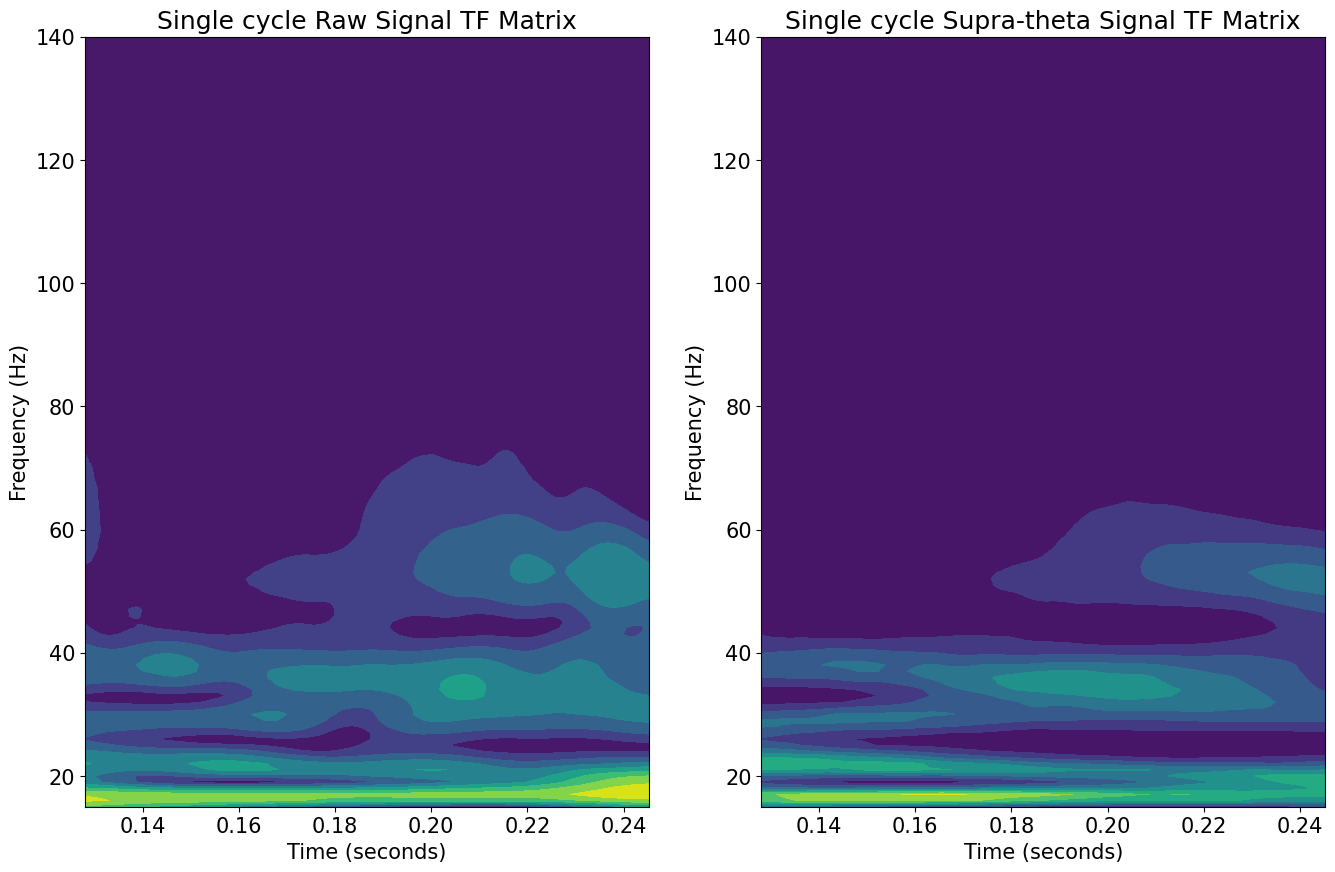

In [102]:
#@title Plotting Time Frequency Matrix of a single cycle of the Raw Signal Wavelet Transform
single_cycle=first_rem_cycles[0]-rem_dict['REM 1']['start-end'][0]
fig,ax=plt.subplots(1,2,figsize=(16,10))
plt.rcParams.update({'font.size': 15})
ax[0].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,first_rem_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[0].set_xlabel(r'Time (seconds)')
ax[0].set_ylabel(r'Frequency (Hz)')
ax[0].set_title('Single cycle Raw Signal TF Matrix')
ax[1].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,supra_theta_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[1].set_xlabel(r'Time (seconds)')
ax[1].set_ylabel(r'Frequency (Hz)')
ax[1].set_title('Single cycle Supra-theta Signal TF Matrix')

In [103]:
#@title Binning samples into respective phase bins

# Define the function to bin time samples into phase segments
def bin_tf_to_fpp(x, power, bin_count):
    """
       Bin time-frequency power data into Frequency Phase Power (FPP) plots using specified time intervals of cycles.

       Parameters:
       x (numpy.ndarray): A 1D or 2D array specifying time intervals of cycles for binning.
           - If 1D, it represents a single time interval [start, end].
           - If 2D, it represents multiple time intervals, where each row is [start, end].
       power (numpy.ndarray): The time-frequency power spectrum data to be binned.
       bin_count (int): The number of bins to divide the time intervals into.

       Returns:
       fpp(numpy.ndarray): Returns FPP plots

       Notes:
       - This function takes time-frequency power data and divides it into FPP plots based on specified
         time intervals.
       - The 'x' parameter defines the time intervals, which can be a single interval or multiple intervals.
       - The 'power' parameter is the time-frequency power data to be binned.
       - The 'bin_count' parameter determines the number of bins within each time interval.
       """

    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

In [104]:
FPP_cycles=bin_tf_to_fpp(first_rem_cycles[:,[0,-1]]-rem_dict['REM 1']['start-end'][0],first_rem_wt,19)
print(f'{FPP_cycles.shape[0]} cycles of {FPP_cycles.shape[1:]} arrays')

331 cycles of (126, 19) arrays


Text(0.5, 1.0, 'Cycle 2')

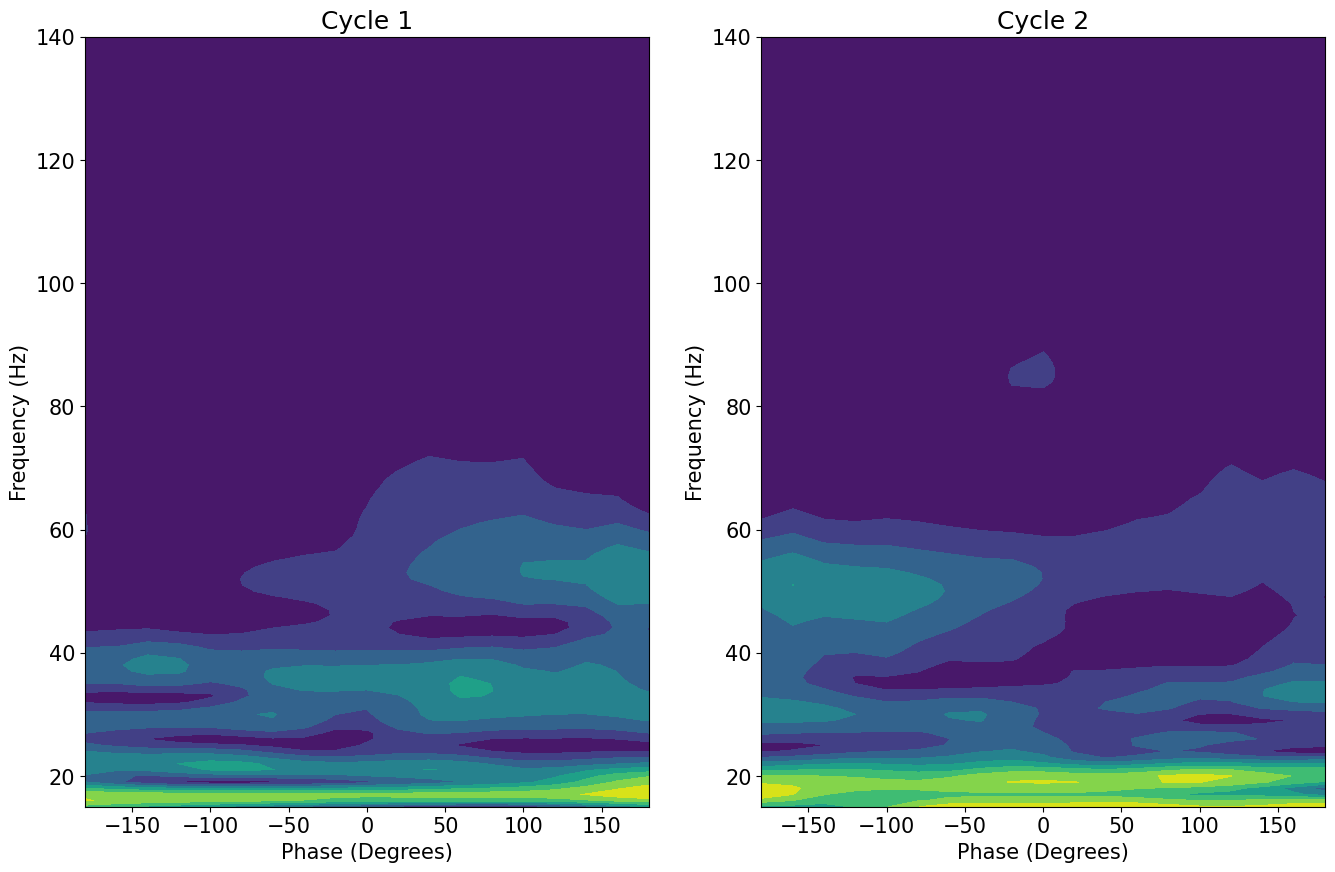

In [108]:
#@title Plotting the FPP plots of the first two cycles
#@markdown Take note of the Phase axis
angles=np.linspace(-180,180,19)
fig,ax=plt.subplots(1,2,figsize=(16,10))
plt.rcParams.update({'font.size': 15})
ax[0].contourf(angles,frequencies,FPP_cycles[0])
ax[0].set_xlabel(r'Phase (Degrees)')
ax[0].set_ylabel(r'Frequency (Hz)')
ax[0].set_title('Cycle 1')
ax[1].contourf(angles,frequencies,FPP_cycles[1])
ax[1].set_xlabel(r'Phase (Degrees)')
ax[1].set_ylabel(r'Frequency (Hz)')
ax[1].set_title('Cycle 2')

# The `get_cycles_data` function

Calling the `get_cycles_data` is an all in one purpose function that provides a lot of information of each REM period, as well as omit REM periods that weremissclassified. Each of the REM periods data is nested in a parent key `['REM <number>']` and the sub-keys stored are the following:

*   `['start-end']`
*   `['wavelet_transform']`
*   `['IMFs']`
*   `['IMF_Frequencies']`
*   `['Instantaneous Phases']`
*   `['Instantaneous Frequencies']`
*   `['Instantaneous Amplitudes']`
*   `['Cycles']`